# 403 RNN Regressor

View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* matplotlib
* numpy

In [58]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
torch.manual_seed(1)    # reproducible

In [60]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

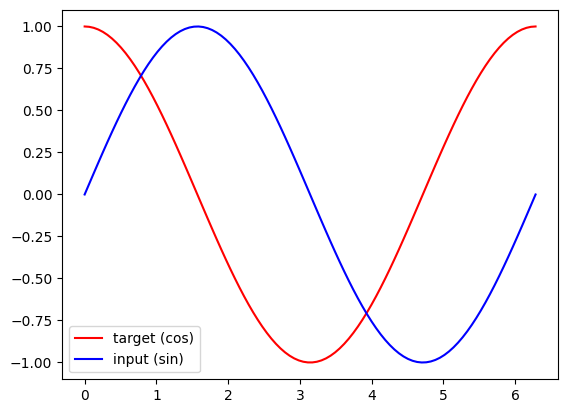

In [61]:
# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)    # float32 for converting torch FloatTensor
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [62]:
DEBUG_RNN = False

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state) # 传递了状态 和LSTM的显著不同是，rnn只得到了h_state，即隐藏层的记忆状态，而LSTM能额外得到c_state，即细胞整体的状态，这体现了LSTM的主线叙事
        if DEBUG_RNN:
            print("\nr_out.shape:",r_out.shape) # torch.Size([1, 10, 32])
            print("\nh_state.shape:",h_state.shape) # torch.Size([1, 1, 32])

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
            if DEBUG_RNN:
                print("\nr_out.size(1):",r_out.size(1)) # 10 和 r_out.size()[1] 相同
                print("\nr_out.size():",r_out.size()) # torch.Size([1, 10, 32])
                break
        # https://docs.pytorch.org/docs/stable/generated/torch.stack.html
        return torch.stack(outs, dim=1), h_state

In [63]:
rnn = RNN()
print(rnn)
h_state = None      # for initial hidden state 初始化隐藏层状态

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [64]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()
plt.figure(1, figsize=(20, 5))

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

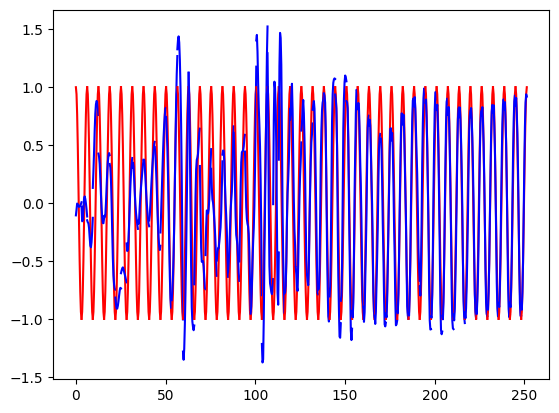

In [65]:
# 训练目标是通过输入sin函数的值，而输出cos函数的值
DEBUG_h_state = False
for step in range(80):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))    # shape (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))

    prediction, h_state = rnn(x, h_state)   # rnn output
    if DEBUG_RNN:
        break
    if DEBUG_h_state:
        print(f"h_state type 1:{type(h_state)}, grad_fn:{h_state.grad_fn}\n")
    # !! next step is important !!
    # h_state = Variable(h_state)        # repack the hidden state, break the connection from last iteration
    h_state.detach_() # 上面是使用Variable(h_state)来解绑梯度，也可以直接用detach_解绑梯度（原地操作）

    if DEBUG_h_state:
        print(f"h_state type 2:{type(h_state)}, grad_fn:{h_state.grad_fn}\n")
        break


    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
plt.draw()